In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import obonet
import BOCC
import pandas as pd
import numpy as np
import math
import typing
import seaborn as sns
import os


/Users/michael/miniconda3/envs/bocc/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Plotting Constants

In [2]:
label_size = 16
tick_label_size = 14
panel_number_size = 24
algos = ['paris-greedy','paris-walktrap','paris-infomap','paris-cesna']
colors = ['#f4cccc','#fff2cc','#d9ead3','#a4c2f4']
algos_colors = {x:c for x,c in zip(algos,colors)}

In [3]:
def clear_ax(ax, top=False, bottom=False, left=False, right=False):
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    # ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
    ax.yaxis.set_tick_params(width=0.0, labelsize=8)
    ax.xaxis.set_tick_params(width=0.0, labelsize=8)

## Load data

In [4]:
# load the edgelists as networkx objects
G15 = nx.read_edgelist('../Edgelists/String_HPO_2015.phenotypic_branch.edgelist.txt')
G16 = nx.read_edgelist('../Edgelists/String_HPO_2016.phenotypic_branch.edgelist.txt')
G17 = nx.read_edgelist('../Edgelists/String_HPO_2017.phenotypic_branch.edgelist.txt')
G18 = nx.read_edgelist('../Edgelists/String_HPO_2018.phenotypic_branch.edgelist.txt')

G19 = nx.read_edgelist('../Edgelists/String_HPO_2019.phenotypic_branch.edgelist.txt')
G20 = nx.read_edgelist('../Edgelists/String_HPO_2020.phenotypic_branch.edgelist.txt')
G21 = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')
G22 = nx.read_edgelist('../Edgelists/String_HPO_2022.phenotypic_branch.edgelist.txt')

In [5]:
# load rediscovery stats
g_snow = pd.read_csv('../SnowballResults/snowball.paris.greedy.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
w_snow = pd.read_csv('../SnowballResults/snowball.paris.walktrap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
i_snow = pd.read_csv('../SnowballResults/snowball.paris.infomap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
c_snow = pd.read_csv('../SnowballResults/snowball.paris.cesna.String_HPO_2020.phenotypic_branch.tsv',sep='\t')

g_snow = pd.read_csv('../SnowballResultsFixed/snowball.paris.greedy.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
w_snow = pd.read_csv('../SnowballResultsFixed/snowball.paris.walktrap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
i_snow = pd.read_csv('../SnowballResultsFixed/snowball.paris.infomap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
c_snow = pd.read_csv('../SnowballResultsFixed/snowball.paris.cesna.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
print(g_snow.shape)
print(w_snow.shape)
print(i_snow.shape)
print(c_snow.shape)

(182900, 5)
(80400, 5)
(385500, 5)
(2847100, 5)


## Plot network size stats by year

In [23]:
# count node and edge type stats
def count_size_stats(_G):
    # count genes
    num_genes = sum(['HP:' not in n for n in _G.nodes])
    # count HPOs
    num_hpos = sum(['HP:' in n for n in _G.nodes])
    # 0 = p2p, 1 = p2g, 2 = p2p
    hpo_counts = [ sum(['HP:' in x for x in e]) for e in _G.edges]
    # count g2p
    num_g2p = hpo_counts.count(1)
    # count g2g
    num_p2p = hpo_counts.count(2)
    # count p2p
    num_g2g = hpo_counts.count(0)
    return [num_genes, num_hpos, num_p2p, num_g2p, num_g2g]

plt_data = {'year':[],'type':[],'count':[]}
# for y,_g in zip(list(range(2015,2023)),[G15,G16,G17,G18,G19,G20,G21]):
for y,_g in zip(list(range(2019,2023)),[G19,G20,G21,G22]):    
    stats = count_size_stats(_g)
    for t,x in zip(['STRING nodes', 'HPO Terms', 'HPO edges', 'gene-2-phenotype', 'STRING edges'],stats):
        plt_data['year'].append(y)
        plt_data['type'].append(t)
        plt_data['count'].append(x)
plt_df = pd.DataFrame(plt_data)

                                        

<Figure size 1080x1080 with 0 Axes>

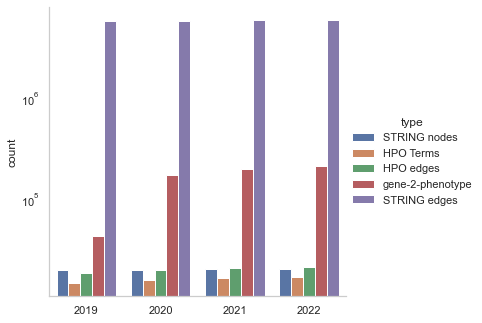

In [24]:
plt.figure(figsize = (15,15))
g=sns.catplot(
    data=plt_df, kind="bar",
    x="year", y="count", hue="type",
    ci="sd")
sns.set(rc={'figure.figsize':(15,15)})
g.set(yscale='log',xlabel='', facecolor='white')
plt.savefig('../Figures/yearly_stats.png',dpi=300)


In [8]:
print(plt_df[plt_df['type'] == 'gene-2-phenotyoe'])

    year              type   count
3   2019  gene-2-phenotyoe   42079
8   2020  gene-2-phenotyoe  170892
13  2021  gene-2-phenotyoe  197926
18  2022  gene-2-phenotyoe  210413


## Calculate Log2Ratio and empirical p-value for each cluster in each algo

In [9]:
def log_2_ratio(o: int, e: typing.List[int]) -> float:
    """
    param o: observed number of rediscoveries
    param e: list of expected number of rediscoveries based on the null model
    """
    return float(np.log2(o / np.median(np.array(e))))

def empircal_p(o: int, e: typing.List[int]) -> float:
    """
    param o: observed number of rediscoveries
    param e: list of expected number of rediscoveries based on the null model
    """
    return float(1 - (sum([ o > x for x in e]) / len(e)))

In [10]:
l2r_p = {'algorith':[],'cluster_id':[],'log2ratio':[],'p-value':[]}

# test the functions
assert(log_2_ratio(2,[2,2,2]) == 0)
assert(log_2_ratio(2,[1,1,1]) > 0)
assert(log_2_ratio(2,[3,3,3]) < 0)
assert(empircal_p(2,[2,2,2]) == 1)
assert(empircal_p(2,[1,1,1]) == 0)
assert(round(empircal_p(2,[3,1,1]),2) == round(float(1/3),2))

# calc log2ratio and p value for each cluster in each algo category. Save it all in one dataframe
for df,algo in zip([g_snow, w_snow, i_snow, c_snow],algos):
    for cid in df['com_id'].unique():
        sub = df[df['com_id'] == cid]
        observed = list(sub['com_score'])[0]
        expected = list(sub['replicate_score'])
        l2r = log_2_ratio(observed,expected)
        p = empircal_p(observed,expected)
        l2r_p['algorith'].append(algo)
        l2r_p['cluster_id'].append(cid)
        l2r_p['log2ratio'].append(l2r)
        l2r_p['p-value'].append(p)
l2r_p_df = pd.DataFrame(l2r_p)
print(l2r_p_df.columns)
print(l2r_p_df.shape)

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_8412/2793826632.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_8412/2793826632.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))


Index(['algorith', 'cluster_id', 'log2ratio', 'p-value'], dtype='object')
(34959, 4)


## Plot Log-2-Ratio vs P-Value

Log-2-ratio non inf max and min nan inf


/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_8412/1642574261.py:7: RuntimeWarning: All-NaN axis encountered
  l2r_max = np.nanmax(arr[arr != np.inf])


paris-greedy
number of infs 0 , 0.0
number of -infs 0 , 0.0
% r > 0 4.866047020229634 %
p < .0001 0.4373974849644614 %
paris-walktrap
number of infs 0 , 0.0
number of -infs 0 , 0.0
% r > 0 4.850746268656716 %
p < .0001 0.6218905472636816 %


/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_8412/1642574261.py:65: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[hist_i][0].set_yscale('log')


paris-infomap
number of infs 0 , 0.0
number of -infs 0 , 0.0
% r > 0 1.9455252918287937 %
p < .0001 0.3631647211413748 %
paris-cesna
number of infs 0 , 0.0
number of -infs 0 , 0.0
% r > 0 1.1274630325594466 %
p < .0001 0.2528889044993151 %


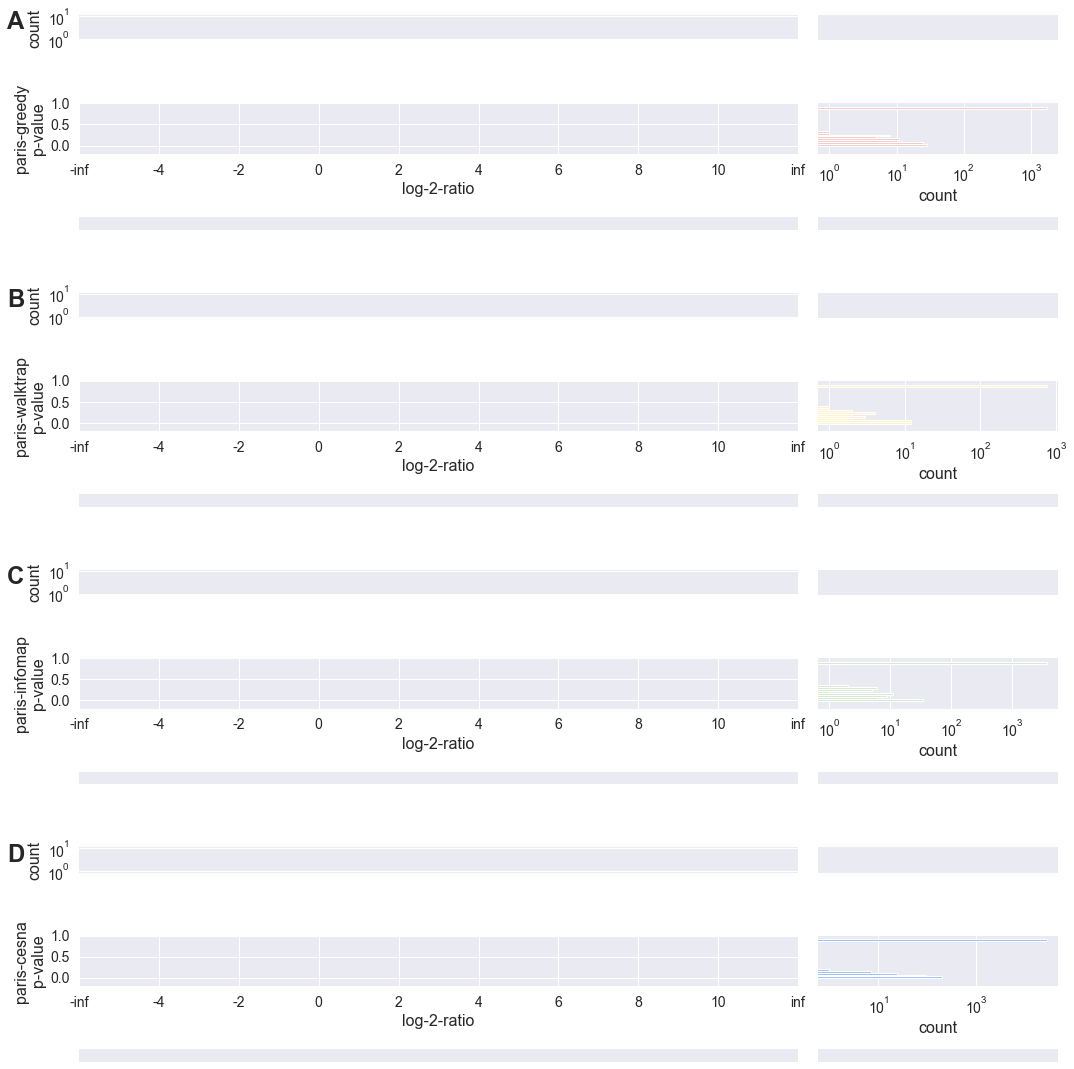

In [11]:
# plot
# for each algo
l2r_p_df = pd.DataFrame(l2r_p)
l2r_p_df = l2r_p_df.sort_values('log2ratio',ascending=False)
arr = l2r_p_df['log2ratio']
l2r_min = np.nanmin(arr[arr != -np.inf])
l2r_max = np.nanmax(arr[arr != np.inf])
print('Log-2-ratio non inf max and min', l2r_max, l2r_min)

# replace INF with 12 (well above the next largest value) and -INF -7 (well below the next lowest)
inf_replacement = 12
neg_inf_replacement = -6
# print(set(l2r_p_df['log2ratio']))
# print(max([x for x in l2r_p_df['log2ratio'] if x != np.inf and not np.isnan(x)]))

# l2r_p_df['log2ratio'] = [inf_replacement if x == np.inf else x for x in l2r_p_df['log2ratio']]
# l2r_p_df['log2ratio'] = [neg_inf_replacement if x == -np.inf else x for x in l2r_p_df['log2ratio']]

# a + 1
# create figure and axes objects
fig, axes = plt.subplots(12,2,gridspec_kw={'width_ratios': [3, 1],'height_ratios': [2, 4, 1, 2, 4, 1, 2, 4, 1, 2, 4, 1]})
fig.set_size_inches(15, 15)

# remove borders and ticks of plots that should be blank space
for i in range(0,12):
    for j in range(2):
        clear_ax(axes[i][j])
        if i % 3 == 0 and j == 1 or i in [2,5,8,11]:
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])

# labels for plot panels
labels = ['A','B','C','D']
for i,algo in enumerate(algos):
    print(algo)
    # establish proper indexes for histograms and scatter plots
    hist_i = i * 3
    scat_i = hist_i + 1
    
    # sub set the df for just this algo
    sub = l2r_p_df[l2r_p_df['algorith'] == algo]
    print('number of infs',sum(sub['log2ratio'] == inf_replacement), ',', sum(sub['log2ratio'] == inf_replacement) / sub.shape[0] )
    print('number of -infs',sum(sub['log2ratio'] == neg_inf_replacement), ',', sum(sub['log2ratio'] == neg_inf_replacement) / sub.shape[0])
    print('% r > 0', (sum(sub['log2ratio'] > 0) / sub.shape[0]) * 100, '%')
    print('p < .0001', (sum(sub['p-value'] <= 0.0001) / sub.shape[0]) * 100, '%' )
    # scatter
    axes[scat_i][0].scatter(sub['log2ratio'],sub['p-value'],c = algos_colors[algo])
    axes[scat_i][0].set_xlim(neg_inf_replacement,inf_replacement)
    # set the x tick and artificially add
    axes[scat_i][0].set_xticks([neg_inf_replacement,-4,-2,0,2,4,6,8,10,inf_replacement])
    axes[scat_i][0].set_xticklabels(['-inf',-4,-2,0,2,4,6,8,10,'inf'])
    axes[scat_i][0].set_ylim(-.2,1)
    axes[scat_i][0].set_ylabel('{}\np-value'.format(algo),size=label_size)
    axes[scat_i][0].set_yticks([0,.5,1])
    axes[scat_i][0].set_xlabel('log-2-ratio',size=label_size)
    axes[scat_i][0].tick_params(axis='both', which='major', labelsize=tick_label_size)
    
    # X hist - above
    hist_bins = axes[hist_i][0].hist(sub['log2ratio'],
                                     bins=np.arange(neg_inf_replacement, inf_replacement + 1, 1),
                                     orientation='vertical',
                                     color = algos_colors[algo])
    axes[hist_i][0].set_xlim(neg_inf_replacement,inf_replacement)
    axes[hist_i][0].set_xticks([])
    axes[hist_i][0].set_yscale('log')
    axes[hist_i][0].set_ylabel('count',size=label_size)
    axes[hist_i][0].tick_params(axis='both', which='major', labelsize=tick_label_size)
    
    # Panel label
    axes[hist_i][0].text(-0.1, 1.15, labels[i], transform=axes[hist_i][0].transAxes,
      fontsize=panel_number_size, fontweight='bold', va='top')
    
    # X hist - right
    axes[scat_i][1].hist(sub['p-value'],bins=20,orientation='horizontal',color = algos_colors[algo])
    axes[scat_i][1].set_ylim(-.2,1.1)
    axes[scat_i][1].set_xscale('log')
    axes[scat_i][1].set_yticks([])
    axes[scat_i][1].set_xlabel('count',size=label_size)
    axes[scat_i][1].tick_params(axis='both', which='major', labelsize=tick_label_size)

plt.tight_layout()
plt.savefig('../Figures/log_vs_p_19v20.png',dpi=300)
plt.show()

In [12]:
# print(np.log2())
print(c_snow.columns)
aa = c_snow[c_snow['com_id'] == 21364]
print(aa)
print(log_2_ratio(list(aa['com_score'])[0],list(aa['replicate_score'])))
temp_o = list(aa['com_score'])[0]
temp_e = list(aa['replicate_score'])
print('O=',temp_o)
print('E=',np.median(np.array(temp_e)))
# float(np.log2(temp_o / np.median(np.array(temp_e))))
print('Neg Inf')
aa = c_snow[c_snow['com_id'] == 18210]
print(aa)
print(log_2_ratio(list(aa['com_score'])[0],list(aa['replicate_score'])))
temp_o = list(aa['com_score'])[0]
temp_e = list(aa['replicate_score'])
print('O=',temp_o)
print('E=',np.median(np.array(temp_e)))
print(np.log2(temp_o / 10))
l2r_p_df['p-value']

Index(['com_id', 'com_score', 'replicate_id', 'replicate_score',
       'rep_and_com_size'],
      dtype='object')
         com_id  com_score  replicate_id  replicate_score  rep_and_com_size
2136400   21364         12             0                0                42
2136401   21364         12             1                0                42
2136402   21364         12             2                0                42
2136403   21364         12             3                0                42
2136404   21364         12             4                0                42
...         ...        ...           ...              ...               ...
2136495   21364         12            95                0                42
2136496   21364         12            96                0                42
2136497   21364         12            97                0                42
2136498   21364         12            98                0                42
2136499   21364         12            99         

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_8412/2793826632.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_8412/2793826632.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_8412/1168395686.py:19: RuntimeWarning: divide by zero encountered in log2
  print(np.log2(temp_o / 10))


108      0.28
19052    0.00
18816    0.03
18773    0.00
18511    0.00
         ... 
34954    1.00
34955    1.00
34956    1.00
34957    1.00
34958    1.00
Name: p-value, Length: 34959, dtype: float64

## Edge Uniqueness

In [13]:
g2p_edges_2021 = [e for e in G21.edges if sum('HP:' in x for x in e) == 1 and e not in G20.edges]
print(len(g2p_edges_2021))
# get a list of rediscoveries per algo
def rediscover(edges,coms):
    """
    @param edges: list of edges [[node1,node2],[node1,node3],..]
    @param coms: list of BOCC objects
    """
    rediscoveries = list()
    for com in coms:
        for edge in edges:
            edge = list(edge)
            if edge[0] in com.members and edge[1] in com.members:
                edge.sort()
                rediscoveries.append(str(edge))
                print(com.name,edge)
    return rediscoveries

def rediscover_with_com_id(edges,coms):
    """
    @param edges: list of edges [[node1,node2],[node1,node3],..]
    @param coms: list of BOCC objects
    """
    rediscoveries = list()
    for com in coms:
        for edge in edges:
            edge = list(edge)
            if edge[0] in com.members and edge[1] in com.members:
                edge.sort()
                rediscoveries.append([com.name,edge])
                print(com.name,edge)
    return rediscoveries


31858


In [14]:
clusters_dict_2020 = {}
for f in os.listdir('../SubComs/2020/'):
    if 'paris' not in f:
        continue
    tmp_coms = BOCC.load_clusters('../SubComs/2020/' + f)
    tmp_name = f.replace('.coms.txt','')
    rediscover(g2p_edges_2021,tmp_coms)
    clusters_dict_2020[tmp_name] = rediscover(g2p_edges_2021,tmp_coms)
    print(tmp_name)
    print(len(clusters_dict_2020[tmp_name]))

59 ['B3GALT6', 'HP:0001999']
59 ['B3GALT6', 'HP:0000768']
59 ['B3GALT6', 'HP:0001075']
59 ['B3GALT6', 'HP:0001634']
59 ['B3GALT6', 'HP:0002974']
60 ['ASXL3', 'HP:0001601']
60 ['ASXL3', 'HP:0002020']
60 ['HP:0001643', 'SALL4']
61 ['HP:0001518', 'MED13L']
61 ['HP:0000233', 'ZMIZ1']
61 ['HP:0004325', 'ZMIZ1']
62 ['ENPP1', 'HP:0001789']
62 ['GPR101', 'HP:0000870']
62 ['HP:0012408', 'SLC34A3']
63 ['FGFR2', 'HP:0005989']
63 ['FGF10', 'HP:0008551']
63 ['HP:0002987', 'LMX1B']
63 ['HP:0100797', 'LMX1B']
64 ['ARID1B', 'HP:0000278']
64 ['HP:0000545', 'SOX11']
65 ['HP:0012411', 'NDN']
66 ['HP:0000003', 'TCTN3']
66 ['CC2D2A', 'HP:0002876']
66 ['HP:0000647', 'TCTN3']
66 ['HP:0001305', 'TCTN3']
66 ['HP:0001747', 'TCTN3']
66 ['HP:0002612', 'TCTN3']
66 ['HP:0006870', 'TCTN3']
66 ['HP:0010459', 'TCTN3']
66 ['HP:0001395', 'PKHD1']
67 ['HP:0012207', 'STK36']
67 ['CCDC39', 'HP:0012207']
68 ['FZD4', 'HP:0000568']
69 ['COL2A1', 'HP:0002654']
69 ['HP:0002938', 'TRPV4']
69 ['HP:0002970', 'TRPV4']
69 ['HP:00028

369 ['HP:0000253', 'MGAT2']
369 ['HP:0002521', 'MGAT2']
369 ['HP:0012171', 'MGAT2']
369 ['HP:0002079', 'PLPBP']
369 ['HP:0002521', 'PLPBP']
369 ['HP:0011968', 'PLPBP']
380 ['HP:0008314', 'NFS1']
403 ['HP:0001397', 'LRPPRC']
426 ['DPM1', 'HP:0012758']
560 ['HP:0008404', 'PKP1']
560 ['HP:0007502', 'PKP1']
560 ['DSC3', 'HP:0007502']
paris.walktrap.2020
161
84 ['ARL6', 'HP:0007843']
84 ['HP:0007737', 'SPATA7']
84 ['HP:0007843', 'SPATA7']
85 ['HP:0000510', 'RLBP1']
85 ['CYP4V2', 'HP:0000618']
2633 ['CCN6', 'HP:0004603']
2669 ['HP:0010880', 'LZTR1']
2672 ['CYP17A1', 'HP:0004319']
2672 ['HP:0000808', 'HSD3B2']
2672 ['HP:0040171', 'HSD3B2']
2672 ['HP:0008221', 'POR']
2672 ['HP:0008232', 'POR']
2672 ['HP:0011969', 'POR']
2678 ['HP:0005227', 'MLH1']
2678 ['HP:0040276', 'MLH1']
2678 ['AAGAB', 'HP:0012126']
2678 ['AAGAB', 'HP:0040276']
2678 ['COL14A1', 'HP:0012126']
2678 ['COL14A1', 'HP:0025092']
2678 ['COL14A1', 'HP:0040276']
2682 ['FAM83H', 'HP:0009102']
2685 ['HP:0002518', 'WARS2']
2686 ['HP:00

3113 ['HP:0003774', 'SLC37A4']
3113 ['HP:0100759', 'SLCO2A1']
3113 ['BTD', 'HP:0000976']
3113 ['HP:0002013', 'SLC19A3']
3141 ['HP:0003076', 'SURF1']
3141 ['HP:0003109', 'SURF1']
3141 ['HP:0003688', 'SURF1']
3141 ['HP:0006565', 'SURF1']
3141 ['COX6A2', 'HP:0002151']
3141 ['COX6A2', 'HP:0003688']
3141 ['COX5A', 'HP:0002151']
3141 ['HP:0002151', 'PET117']
3159 ['HP:0031951', 'NPRL2']
3159 ['HP:0031951', 'NPRL3']
3185 ['FGF10', 'HP:0000089']
3185 ['FGF10', 'HP:0000813']
3216 ['HESX1', 'HP:0008202']
3216 ['HP:0000824', 'PROP1']
3216 ['HP:0000824', 'LHX4']
3216 ['HP:0008202', 'LHX4']
3216 ['HP:0000824', 'POU1F1']
3216 ['HP:0008202', 'POU1F1']
3216 ['HP:0001943', 'LHX3']
3216 ['HP:0008202', 'LHX3']
3223 ['DUOXA2', 'HP:0000851']
3223 ['HP:0000851', 'SLC5A5']
3223 ['HP:0000851', 'TG']
3223 ['HP:0000851', 'TPO']
3223 ['HP:0008223', 'TSHR']
3224 ['HP:0001034', 'KRT5']
3224 ['HP:0005585', 'KRT5']
3224 ['HP:0007599', 'KRT5']
3225 ['HP:0002308', 'MLXIPL']
3225 ['HP:0007720', 'MLXIPL']
3230 ['COL1A2'

3012 ['HP:0011108', 'STK36']
3012 ['HP:0012207', 'STK36']
3012 ['HP:0012265', 'STK36']
3012 ['CCDC39', 'HP:0012207']
3012 ['CCDC39', 'HP:0012735']
3012 ['DNAJB13', 'HP:0011108']
3012 ['CCDC40', 'HP:0012735']
3013 ['HP:0001177', 'TCTN1']
3013 ['HP:0001177', 'TMEM237']
3013 ['HP:0000200', 'KIAA0753']
3013 ['HP:0002335', 'PDE6D']
3024 ['EBF3', 'HP:0007021']
3025 ['HEY2', 'HP:0000023']
3036 ['HP:0000154', 'NEXMIF']
3036 ['HP:0003189', 'NEXMIF']
3036 ['CHAMP1', 'HP:0006829']
3042 ['CLCNKA', 'HP:0001324']
3042 ['CLCNKA', 'HP:0000841']
3042 ['CLCNKA', 'HP:0000848']
3042 ['CLCNKA', 'HP:0002917']
3042 ['BSND', 'HP:0001324']
3042 ['BSND', 'HP:0000841']
3042 ['BSND', 'HP:0000848']
3042 ['BSND', 'HP:0002917']
3042 ['HP:0001824', 'SLC34A2']
3042 ['HP:0012387', 'SLC34A2']
3049 ['HP:0002421', 'NDUFA8']
3049 ['HP:0003128', 'NDUFA8']
3049 ['HP:0004900', 'NDUFS4']
3049 ['HP:0002643', 'NDUFB10']
3068 ['COL2A1', 'HP:0002654']
3068 ['COL2A1', 'HP:0004592']
3068 ['COL2A1', 'HP:0005787']
3068 ['HP:0003016', 

1092 ['APOL1', 'HP:0012579']
1104 ['HP:0007773', 'TSPAN12']
1106 ['HP:0100646', 'IL2RA']
1106 ['HP:0005403', 'IL2RG']
1106 ['CD247', 'HP:0001890']
1106 ['CD247', 'HP:0003212']
1106 ['CD247', 'HP:0003261']
1106 ['CD247', 'HP:0003496']
1106 ['HP:0003212', 'IL2RA']
1106 ['HP:0031382', 'IL2RA']
1106 ['HP:0005401', 'IL12RB1']
1109 ['HP:0001945', 'PKHD1']
1109 ['HP:0012178', 'PRKCD']
1109 ['HP:0001971', 'PSAP']
1109 ['HP:0001744', 'UNC13D']
1121 ['HP:0007524', 'NF1']
1121 ['GPR101', 'HP:0000870']
1125 ['HP:0000520', 'SPTBN1']
1125 ['HP:0003418', 'SPTBN1']
1137 ['FGF23', 'HP:0002748']
1137 ['DSPP', 'HP:0009722']
1138 ['HP:0003401', 'NEFL']
1138 ['HP:0007340', 'NEFL']
1138 ['HP:0003324', 'SLC16A2']
1138 ['HP:0007340', 'MPZ']
1138 ['HP:0007340', 'PMP22']
1138 ['HP:0031006', 'PMP22']
1168 ['COL6A2', 'HP:0002515']
1168 ['COL6A2', 'HP:0003691']
1170 ['HESX1', 'HP:0000871']
1170 ['HESX1', 'HP:0008202']
1170 ['HESX1', 'HP:0030341']
1170 ['HESX1', 'HP:0030344']
1170 ['HP:0000044', 'LHX3']
1170 ['HP:0

1036 ['HP:0000735', 'SYNGAP1']
1036 ['HP:0002332', 'SYNGAP1']
1042 ['HBB', 'HP:0004817']
1042 ['HP:0004444', 'RHAG']
1042 ['HP:0001878', 'RHCE']
1042 ['HP:0001923', 'RHCE']
1042 ['HP:0004444', 'RHCE']
1042 ['HP:0005502', 'RHCE']
1042 ['HP:0001878', 'RHD']
1042 ['HP:0001923', 'RHD']
1042 ['HP:0004444', 'RHD']
1042 ['HP:0005502', 'RHD']
1045 ['HP:0002014', 'SLC5A1']
1045 ['HP:0004395', 'SLC5A1']
1052 ['HP:0012727', 'MYH11']
1052 ['HP:0004970', 'MYH11']
1052 ['COL3A1', 'HP:0004933']
1052 ['COL3A1', 'HP:0012499']
1052 ['FOXE3', 'HP:0004942']
1052 ['HP:0004970', 'TGFB2']
1052 ['HP:0031056', 'THSD1']
1054 ['GDF1', 'HP:0000961']
1054 ['GDF1', 'HP:0030148']
1054 ['HP:0000961', 'NKX2-6']
1054 ['HP:0001642', 'NKX2-6']
1054 ['HP:0004935', 'NKX2-6']
1071 ['CFHR3', 'HP:0045042']
1071 ['CFH', 'HP:0011506']
1073 ['FOXF1', 'HP:0002202']
1074 ['COL2A1', 'HP:0002654']
1074 ['COL2A1', 'HP:0005193']
1074 ['COL11A2', 'HP:0001376']
1074 ['HP:0005086', 'MMP13']
1074 ['HP:0003184', 'MATN3']
1075 ['HP:0008511'

3975 ['HP:0000316', 'PUS7']
3975 ['HP:0011968', 'PUS7']
3975 ['BCORL1', 'HP:0000218']
3975 ['BCORL1', 'HP:0011968']
3975 ['CAMK2A', 'HP:0002079']
4045 ['HP:0002077', 'TREX1']
4081 ['HP:0000407', 'KCNJ16']
4162 ['HP:0000218', 'SHOC2']
4162 ['HP:0000508', 'SHOC2']
4162 ['HP:0000639', 'PPP1CB']
4162 ['HP:0002650', 'PPP1CB']
4259 ['HP:0001830', 'TMEM237']
4263 ['HP:0006808', 'PLP1']
4279 ['CCN6', 'HP:0006429']
4279 ['CCN6', 'HP:0100864']
4280 ['HP:0003025', 'MMP13']
4398 ['ATP1A3', 'HP:0002063']
4398 ['ATP1A3', 'HP:0100710']
4399 ['ATP13A2', 'HP:0002322']
4707 ['HP:0003547', 'TPM2']
4707 ['HP:0003749', 'TPM2']
4707 ['ACTA1', 'HP:0003547']
4707 ['ACTA1', 'HP:0003749']
4792 ['HP:0001631', 'NKX2-6']
4809 ['HBA1', 'HP:0001901']
4809 ['HBA2', 'HP:0001901']
4810 ['HP:0001923', 'UROS']
4898 ['HP:0033188', 'PSTPIP1']
4952 ['HP:0000369', 'RAB3GAP1']
5039 ['GPR68', 'HP:0000705']
5154 ['HP:0003774', 'SMARCAL1']
5154 ['EMP2', 'HP:0003774']
5224 ['HP:0000518', 'RP1L1']
5370 ['ESCO2', 'HP:0000508']
5460

16044 ['HP:0001562', 'MYH11']
16044 ['HP:0002089', 'MYH11']
16044 ['HP:0100519', 'MYH11']
16044 ['EFEMP2', 'HP:0002093']
16044 ['HP:0002089', 'WT1']
16056 ['ALDOA', 'HP:0001878']
16056 ['ALDOA', 'HP:0001945']
16056 ['ALDOA', 'HP:0003326']
16110 ['EIF5A', 'HP:0000316']
16110 ['HP:0000316', 'SLC12A2']
16110 ['HP:0001270', 'SLC12A2']
16293 ['HP:0001251', 'XRCC4']
16365 ['HP:0031381', 'PNP']
16365 ['HP:0005403', 'IL2RG']
16365 ['CD247', 'HP:0001508']
16365 ['HP:0001019', 'IL2RA']
16365 ['HP:0001508', 'IL2RA']
16365 ['HP:0009098', 'IL2RA']
16642 ['HLA-DQB1', 'HP:0001596']
16642 ['HP:0001890', 'ITK']
16642 ['HP:0001973', 'ITK']
16702 ['HP:0002240', 'MTX2']
16702 ['HP:0002240', 'SLC9A3']
16703 ['HP:0000316', 'SPTBN1']
16703 ['HP:0000431', 'SPTBN1']
16703 ['HP:0001659', 'SPTBN1']
16778 ['HP:0001508', 'HSD3B2']
16778 ['HP:0001508', 'MCM4']
16796 ['ERBB2', 'HP:0001249']
16871 ['HP:0000028', 'SIX3']
16936 ['HP:0007370', 'SIX3']
17025 ['HP:0002342', 'NDUFAF5']
17046 ['HP:0011968', 'IARS1']
17142 [

26704 ['ALG3', 'HP:0002079']
26704 ['HP:0002079', 'KIF1A']
26704 ['HP:0000648', 'VPS53']
26813 ['HP:0004322', 'ITCH']
26813 ['HP:0001511', 'USP9X']
26836 ['HP:0000252', 'NEXMIF']
26836 ['HP:0002317', 'NEXMIF']
26982 ['HDAC4', 'HP:0010743']
26982 ['FBN1', 'HP:0010743']
27216 ['HP:0100490', 'HSPG2']
27216 ['HP:0005280', 'HSPG2']
27228 ['HP:0001397', 'SLC37A4']
27244 ['GLI2', 'HP:0000316']
27276 ['HP:0001081', 'STX1A']
27276 ['HP:0002637', 'STX1A']
27276 ['CFTR', 'HP:0001047']
27277 ['HP:0012378', 'UBA1']
27612 ['HP:0002365', 'TSEN34']
27712 ['HP:0011800', 'SATB1']
27712 ['HP:0000490', 'NF1']
28114 ['HP:0001873', 'ITGB3']
28114 ['HP:0001873', 'THPO']
28203 ['CEP19', 'HP:0002230']
28215 ['GRIN2A', 'HP:0002376']
28215 ['GRIN2A', 'HP:0200134']
28369 ['CUX1', 'HP:0000252']
28 ['FGFR1', 'HP:0008501']
28 ['HP:0000047', 'HSPG2']
28 ['HP:0000520', 'HSPG2']
28 ['HP:0001156', 'HSPG2']
28 ['HP:0011800', 'HSPG2']
105 ['EEF1A2', 'HP:0002079']
105 ['EEF1A2', 'HP:0002465']
105 ['GRIN2A', 'HP:0001332']
1

7485 ['HP:0001310', 'SPG7']
7685 ['GBA', 'HP:0007957']
7717 ['HP:0000316', 'PRKACB']
7728 ['FOXP3', 'HP:0001263']
7811 ['HP:0002716', 'PTPN22']
7812 ['HP:0011227', 'PSMB8']
7812 ['HLA-DRB1', 'HP:0002633']
7812 ['HP:0011227', 'MVK']
7812 ['HP:0003565', 'IL1RN']
7812 ['HP:0011227', 'IL1RN']
7930 ['HP:0002360', 'HTT']
7957 ['ABCC6', 'HP:0001250']
8015 ['DSC3', 'HP:0000653']
8027 ['ABCC8', 'HP:0004904']
8324 ['HP:0000252', 'PTEN']
8324 ['HMGA2', 'HP:0000369']
8325 ['HP:0001256', 'RPS6KA3']
8347 ['HP:0000431', 'MECP2']
8499 ['HP:0001263', 'PHKA2']
8633 ['HP:0001252', 'HUWE1']
8633 ['HP:0001519', 'HUWE1']
8735 ['AR', 'HP:0000823']
8753 ['HP:0000369', 'SPEN']
8769 ['HP:0001250', 'SLC16A2']
8769 ['HP:0001332', 'SLC16A2']
8813 ['GLB1', 'HP:0001250']
8813 ['CLN8', 'HP:0000726']
9083 ['HP:0001263', 'YIPF5']
9099 ['CASQ2', 'HP:0001678']
9099 ['HP:0001678', 'RYR2']
9131 ['HP:0001305', 'TCTN1']
9242 ['HP:0000316', 'ITCH']
9242 ['HP:0000316', 'TCF20']
9322 ['HP:0009718', 'IFNG']
9390 ['DALRD3', 'HP:0

19194 ['HP:0025190', 'NEXMIF']
19194 ['CHD2', 'HP:0025190']
19194 ['CHD2', 'HP:0031475']
19320 ['ALG12', 'HP:0001250']
19321 ['HP:0001263', 'PIGF']
19398 ['HP:0001252', 'SHH']
19790 ['HP:0012721', 'RASA1']
19838 ['ERBB2', 'HP:0001249']
19872 ['ARID1A', 'HP:0000545']
19872 ['ARID1A', 'HP:0001629']
19872 ['HP:0000365', 'KMT2C']
19872 ['ASXL1', 'HP:0000463']
19872 ['HP:0000574', 'KDM5C']
19872 ['HP:0001263', 'KDM5C']
19872 ['HP:0000218', 'SYNGAP1']
19872 ['HP:0000463', 'SYNGAP1']
19872 ['HP:0001159', 'SYNGAP1']
20013 ['HP:0002653', 'SLC34A1']
20013 ['HP:0002749', 'SLC34A1']
20013 ['HP:0004912', 'SLC34A1']
20013 ['FGF23', 'HP:0002748']
20131 ['GALC', 'HP:0000712']
20182 ['FANCC', 'HP:0005528']
20182 ['FANCD2', 'HP:0005528']
20207 ['HP:0001508', 'SLC37A4']
20374 ['DYRK1A', 'HP:0001508']
20402 ['HP:0002089', 'MBTPS2']
20716 ['HP:0000175', 'TCTN1']
20742 ['HP:0002729', 'PRKCD']
20742 ['HP:0003496', 'RASGRP1']
20819 ['FGF13', 'HP:0001268']
20819 ['FGF13', 'HP:0001336']
20819 ['FGF13', 'HP:0002

In [15]:
# calc data for uniqueness
uniq_rediscovery = {'algo':[],'infotype':[],'count':[]}
# all_rediscoveries = list()
# for key in rediscovery_res.keys():
#     all_rediscoveries = all_rediscoveries + rediscovery_res[key]
# all_rediscoveries_set = set(all_rediscoveries)

for key in clusters_dict_2020.keys():
    all_rediscoveries = list()
    for key2 in clusters_dict_2020.keys():
        if key == key2:
            continue
        all_rediscoveries = all_rediscoveries + clusters_dict_2020[key2]
    
    all_rediscoveries_set = set(all_rediscoveries)
    print(len(all_rediscoveries_set))
    print(key)
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('total')
    uniq_rediscovery['count'].append(len(clusters_dict_2020[key]))
    
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('total unique self')
    uniq_rediscovery['count'].append(len(set(clusters_dict_2020[key])))
    
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('common')
    uniq_rediscovery['count'].append(len([x for x in set(clusters_dict_2020[key]) if x in all_rediscoveries_set]))
    
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('unique')
    uniq_rediscovery['count'].append(len([x for x in set(clusters_dict_2020[key]) if x not in all_rediscoveries_set]))

uniq_rediscovery_df = pd.DataFrame(uniq_rediscovery)
print(uniq_rediscovery_df.shape)
assert(uniq_rediscovery_df.shape[0] == 4 * 4)

1261
paris.walktrap.2020
1149
paris.infomap.2020
1134
paris.greedy.2020
737
paris.cesna.2020
(16, 3)


                   algo           infotype  count
0   paris.walktrap.2020              total    161
1   paris.walktrap.2020  total unique self    161
2   paris.walktrap.2020             common     38
3   paris.walktrap.2020             unique    123
4    paris.infomap.2020              total    328
5    paris.infomap.2020  total unique self    328
6    paris.infomap.2020             common     93
7    paris.infomap.2020             unique    235
8     paris.greedy.2020              total    342
9     paris.greedy.2020  total unique self    334
10    paris.greedy.2020             common     84
11    paris.greedy.2020             unique    250
12     paris.cesna.2020              total    750
13     paris.cesna.2020  total unique self    705
14     paris.cesna.2020             common     58
15     paris.cesna.2020             unique    647
unique: 1255
total unique self: 1528
common: 273


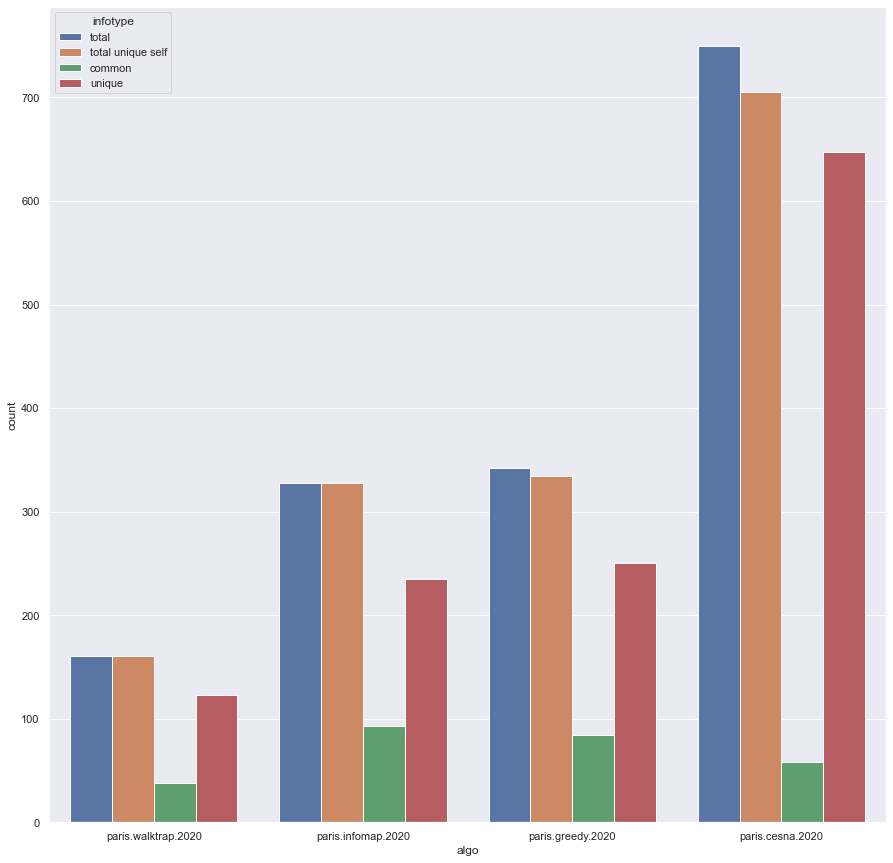

In [16]:
# plot it
print(uniq_rediscovery_df)
print('unique:',sum(uniq_rediscovery_df[uniq_rediscovery_df['infotype'] == 'unique']['count']))
print('total unique self:',sum(uniq_rediscovery_df[uniq_rediscovery_df['infotype'] == 'total unique self']['count']))
print('common:',sum(uniq_rediscovery_df[uniq_rediscovery_df['infotype'] == 'common']['count']))
sns.barplot(data=uniq_rediscovery_df,x='algo',y='count',hue='infotype')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.savefig('../Figures/2021_rediscovery_on_2020_uniqness.jpg', dpi=300)
plt.show()

## HPO to Gene Edges Infered from MPO

In [17]:
hpo_from_mpo = pd.read_csv('../Resources/hpo_to_gene_derived_by_mpo.edgelist.2021.unique.txt',sep='\t',header=None)
print(hpo_from_mpo)
hpo_from_mpo.columns = ['HPO','Gene','Name']

             0       1                                     2
0   HP:0000086  FANCD2                        Ectopic kidney
1   HP:0000093    G6PC                           Proteinuria
2   HP:0000097    G6PC    Focal segmental glomerulosclerosis
3   HP:0000105    G6PC                       Enlarged kidney
4   HP:0000238    MSH2                         Hydrocephalus
..         ...     ...                                   ...
80  HP:0011463     XPC                       Childhood onset
81  HP:0012213    G6PC  Decreased glomerular filtration rate
82  HP:0020073    MSH2                  Hypopigmented macule
83  HP:0030052    MSH2                    Inguinal freckling
84  HP:0100697    MSH2                     Neurofibrosarcoma

[85 rows x 3 columns]


In [18]:
# hpo_mpo_edges = [[row['HPO'],row['Gene']] for i,row in hpo_from_mpo.iterrows()]
# hpo_mpo_clusters_dict_2021 = {}
# all_new_mpo_edges = []
# for f in os.listdir('../SubComs/2021/'):
#     if 'paris' not in f:
#         continue
#     tmp_coms = BOCC.load_clusters('../SubComs/2021/' + f)
#     # remove coms that are not sig
#     tmp_name = f.replace('.coms.txt','')
#     hpo_mpo_clusters_dict_2021[tmp_name] = rediscover_with_com_id(hpo_mpo_edges,tmp_coms)

#     for res in hpo_mpo_clusters_dict_2021[tmp_name]:
#         print('{algo}:{id}\t{g}\t{h}'.format(algo=tmp_name,id=str(res[0]),
#                                          g=res[1][0],
#                                          h=res[1][1]))
#     all_new_mpo_edges = all_new_mpo_edges + hpo_mpo_clusters_dict_2021[tmp_name]
    
hpo_mpo_edges = [[row['HPO'],row['Gene']] for i,row in hpo_from_mpo.iterrows()]
hpo_mpo_clusters_dict_2021 = {}
all_new_mpo_edges = []

tmp_coms = BOCC.load_clusters('../WebPage/all_predicted_sign_clusters.2021.txt')
# remove coms that are not sig
tmp_name = f.replace('.coms.txt','')
hpo_mpo_clusters_dict_2021[tmp_name] = rediscover_with_com_id(hpo_mpo_edges,tmp_coms)

for res in hpo_mpo_clusters_dict_2021[tmp_name]:
    print('{algo}:{id}\t{g}\t{h}'.format(algo=tmp_name,id=str(res[0]),
                                     g=res[1][0],
                                     h=res[1][1]))
all_new_mpo_edges = all_new_mpo_edges + hpo_mpo_clusters_dict_2021[tmp_name]

# print(set(all_new_mpo_edges))
# print(len(set(all_new_mpo_edges)))

paris.cesna.2021:14597 ['HP:0001263', 'TDGF1']
paris.cesna.2020:paris.cesna.2021:14597	HP:0001263	TDGF1


## Mouse Snowballing Results

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_8412/2793826632.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_8412/2793826632.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))


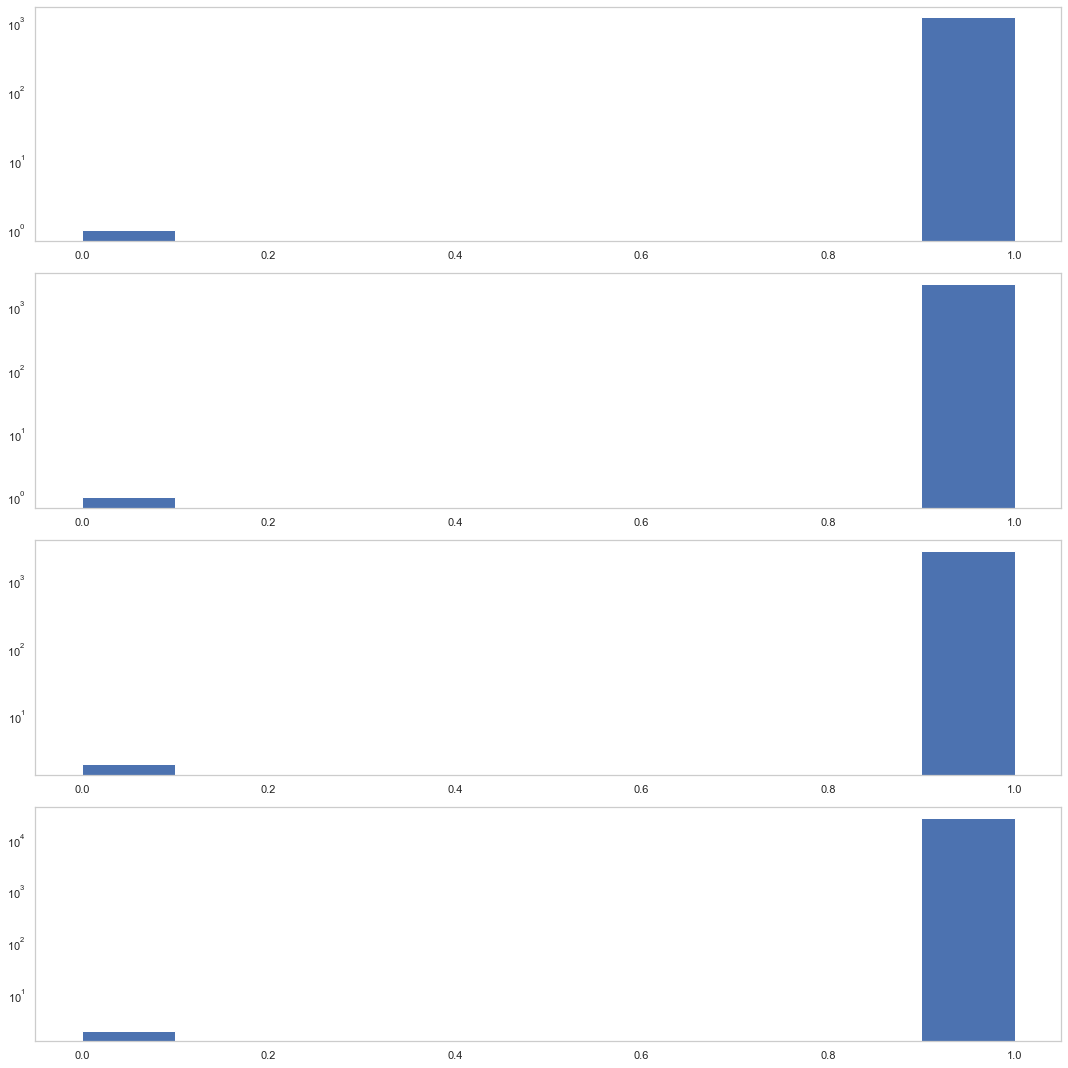

Index(['algorithm', 'cluster_id', 'log2ratio', 'p-value'], dtype='object')
(32767, 4)


In [19]:
import os
import pandas as pd
mouse_snow_dfs = []
mouse_files = ['snowball.paris.greedy.String_HPO_2021.mouse.phenotypic_branch.tsv',
              'snowball.paris.walktrap.String_HPO_2021.mouse.phenotypic_branch.tsv',
              'snowball.paris.infomap.String_HPO_2021.mouse.phenotypic_branch.tsv',
              'snowball.paris.cesna.String_HPO_2021.mouse.phenotypic_branch.tsv']

for i,file in enumerate(mouse_files):
    tmp_df = pd.read_csv('../MouseSnowballResults/'+file,sep='\t')
    mouse_snow_dfs.append(tmp_df)


mouse_l2r_p = {'algorithm':[],'cluster_id':[],'log2ratio':[],'p-value':[]}
algos = ['paris-greedy','paris-walktrap','paris-infomap','paris-cesna']
# print stats for all DFs
# calc log2ratio and p value for each cluster in each algo category. Save it all in one dataframe
for df,algo in zip(mouse_snow_dfs, algos):
    for cid in df['com_id'].unique():
        sub = df[df['com_id'] == cid]
        observed = list(sub['com_score'])[0]
        expected = list(sub['replicate_score'])
        l2r = log_2_ratio(observed,expected)
        p = empircal_p(observed,expected)
        mouse_l2r_p['algorithm'].append(algo)
        mouse_l2r_p['cluster_id'].append(cid)
        mouse_l2r_p['log2ratio'].append(l2r)
        mouse_l2r_p['p-value'].append(p)
mouse_l2r_p_df = pd.DataFrame(mouse_l2r_p)

fig, axes = plt.subplots(4)
for i,algo in enumerate(algos):
    sub = mouse_l2r_p_df[mouse_l2r_p_df['algorithm'] == algo]
    axes[i].hist(sub['p-value'])
    axes[i].set_yscale('log')
plt.tight_layout()
plt.show()
print(mouse_l2r_p_df.columns)
print(mouse_l2r_p_df.shape)

0.0
6
1.0
32761
paris-greedy 956 4 2
Total synthetic wins 113
121800
Total synthetic wins p-value 0.9990722495894909
paris-walktrap 1309 4 2
Total synthetic wins 218
230100
Total synthetic wins p-value 0.9990525858322469
paris-infomap 1697 2 0
paris-infomap 1828 2 0
Total synthetic wins 93
272300
Total synthetic wins p-value 0.9996584649283878
paris-cesna 14597 2 0
paris-cesna 22354 2 0
Total synthetic wins 1688
2652500
Total synthetic wins p-value 0.9993636192271442


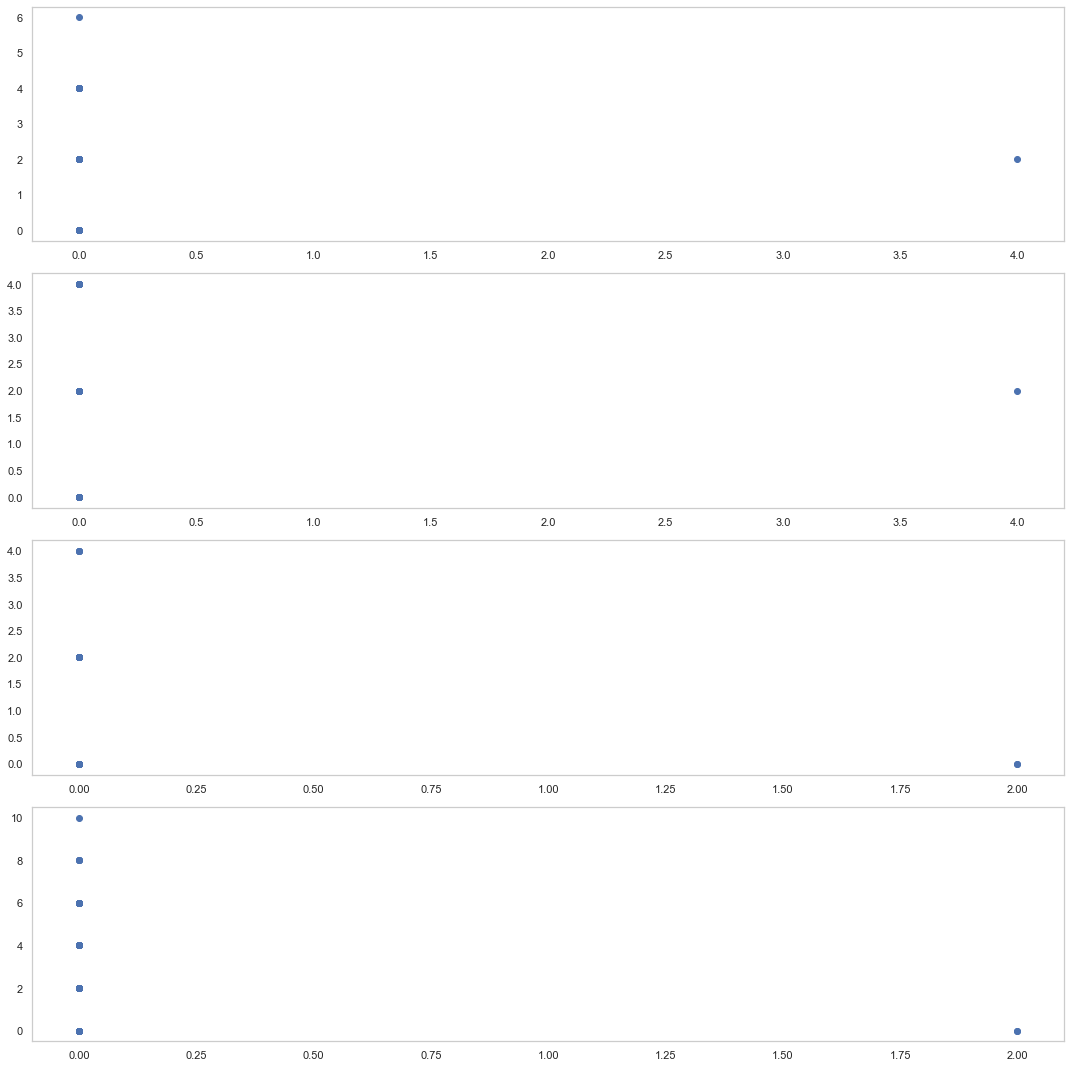

'\nThe past two results show me that the vast majority of clusters have\np = 1.0 where both the real cluster and synthetic replicate have 0 rediscoveries.\nHowever there are still cases where synthetic beats the real clusters in a minority of cases.\nTo invert the problem there is a p=0.99 that the null model is better than the actual clusters.\nSo based on the mouse edges, there is no difference between our clusters and snowball samplings.\nBut in the 6 cases our clusters actually rediscover something, they are all p < 0.0001.\nI think part of null results is due to limited information.\nThere were only 85 edges we could test with.\nSeveral orders of magnitude less than the rediscover sims from previous years.\n'

In [20]:
print(mouse_l2r_p_df['p-value'].min())
print(sum(mouse_l2r_p_df['p-value'] == mouse_l2r_p_df['p-value'].min()))
print(mouse_l2r_p_df['p-value'].max())
print(sum(mouse_l2r_p_df['p-value'] == mouse_l2r_p_df['p-value'].max()))

fig, axes = plt.subplots(4)
for i, df in enumerate(mouse_snow_dfs):
    xs = []
    ys = []
    synth_wins = 0
    reals_wins = 0
    for com_id in df['com_id'].unique():
        sub = df[df['com_id'] == com_id]
        xs.append(list(sub['com_score'])[0])
        ys.append(sub['replicate_score'].max())
        if list(sub['com_score'])[0] > 0:
            print(algos[i], com_id, list(sub['com_score'])[0], sub['replicate_score'].max())
        if list(sub['com_score'])[0] > 0 and  list(sub['com_score'])[0] > sub['replicate_score'].max():
            reals_wins += 1
        if sub['replicate_score'].max() > list(sub['com_score'])[0]:
            synth_wins += 1
#             print('Synthetic win:', algos[i], com_id, list(sub['com_score'])[0], sub['replicate_score'].max())
    print('Total synthetic wins',synth_wins )
    print(df.shape[0])
    print('Total synthetic wins p-value',1 - (synth_wins / df.shape[0])  )
    
            
    axes[i].scatter(xs,ys)
plt.tight_layout()
plt.show()

"""
The past two results show me that the vast majority of clusters have
p = 1.0 where both the real cluster and synthetic replicate have 0 rediscoveries.
However there are still cases where synthetic beats the real clusters in a minority of cases.
To invert the problem there is a p=0.99 that the null model is better than the actual clusters.
So based on the mouse edges, there is no difference between our clusters and snowball samplings.
But in the 6 cases our clusters actually rediscover something, they are all p < 0.0001.
I think part of null results is due to limited information.
There were only 85 edges we could test with.
Several orders of magnitude less than the rediscover sims from previous years.
"""


## Distance between nodes with and without pruning

In [21]:
# load the unpruned version of a graph
G20_no_prune = nx.read_edgelist('../Edgelists/String_HPO_2020.all_hpo.edgelist.txt')

In [22]:
# get all genes connected to HP:0000007 - Autosomal dominant inheritance
neighbors = G20_no_prune.neighbors('HP:0000007')
gene_neighs = [x for x in neighbors if 'HP:' not in x]
# everything in gene_neighs has a path of length 3
# find 2 genes with a shortest path > 2 in the pruned on
import random
random.seed(0)
longest_shortest_len = 0
longest_shortest = []
for i in range(10000):
    nodes = random.sample(gene_neighs, 2)
    if 'protein1' in nodes or 'protein2' in nodes or 'Info' in nodes or 'entrez-gene-id<tab>entrez-gene-symbol<tab>HPO-Term-Name<tab>HPO-Term-ID<tab>Frequency-Raw<tab>Frequency-HPO<tab>Additional' in nodes:
        continue
    path = nx.shortest_path(G20, nodes[0], nodes[1])
    if len(path) > longest_shortest_len:
        longest_shortest = path
        longest_shortest_len = len(path)
        print(str(path),len(path))
print(longest_shortest)
    

['NEK2', 'SGK494', 'SERPINF2'] 3
['DOCK8', 'ACTB', 'HP:0000252', 'AARS1'] 4
['CIBAR1', 'HP:0001162', 'MKKS', 'HP:0001249', 'IMPA1'] 5
['MPIG6B', 'HP:0001873', 'CDC42', 'ADCY1', 'HP:0000399', 'RIPOR2'] 6
['MPIG6B', 'HP:0001873', 'CDC42', 'ADCY1', 'HP:0000399', 'RIPOR2']
